# Project Master DS
Malware binary classification

Pietro Marincola

https://ieee-dataport.org/open-access/malware-analysis-datasets-raw-pe-image

In [37]:
#Libraries
# importing necessary libraries
import pandas as pd
import numpy as np
from collections import Counter
# To convert to categorical data
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import GridSearchCV, train_test_split

from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RepeatedEditedNearestNeighbours,RandomUnderSampler

#libraries for building model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout,Flatten
from tensorflow.keras.datasets import cifar10


from tensorflow import keras

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Dataset

In [32]:
orig_visual_malware_dataset = pd.read_csv('./raw_pe_images.csv')

## Dataset info & pre-processing
- hash feature = malware id
- pixel features= 1024 because of conversion 32 x 32 greyscale image
- flattened to a 1024 bytes vector
- label feature = malware

- Column name: malware
Description: Class
Type: 0 (Goodware) or 1 (Malware)
- Stratification: not balance between classes
- inbalance classes - use imblearn


In [9]:
orig_visual_malware_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51959 entries, 0 to 51958
Columns: 1026 entries, hash to malware
dtypes: int64(1025), object(1)
memory usage: 406.7+ MB


### General

In [33]:
#create label dataset
visual_malware_label = orig_visual_malware_dataset['malware']
#remove unecessary columns
visual_malware_dataset = orig_visual_malware_dataset.drop(['hash','malware'], axis=1)
visual_malware_dataset.head(2)

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_1014,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023
0,15,15,239,15,223,36,102,243,102,102,...,255,31,242,245,169,212,17,255,160,122
1,234,196,8,20,182,56,27,223,144,255,...,213,189,228,156,54,189,82,177,125,193


### Under & Over Sampler

In [34]:
X_train, X_test, y_train, y_test = train_test_split(visual_malware_dataset, visual_malware_label,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    shuffle= True,
                                                    stratify=visual_malware_label)
#Under
rus = RandomUnderSampler(random_state=0, replacement=True)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_under))
#Over
ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_over))

Resampled dataset shape Counter({0: 1808, 1: 1808})
Resampled dataset shape Counter({1: 34563, 0: 34563})


In [67]:
print('X_train:', X_train_under.shape)
print('y_train:', y_train_under.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3616, 1024)
y_train: (3616,)
X_test: (15588, 1024)
y_test: (15588,)


In [35]:
#shape of the dataset
X_train_under = X_train_under/255
X_test = X_test/255

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
print(X_train_under)


         pix_0     pix_1     pix_2     pix_3     pix_4     pix_5     pix_6  \
0     0.000000  0.250980  0.458824  0.721569  0.031373  0.513725  0.000000   
1     0.000000  0.000000  0.454902  0.000000  0.000000  0.000000  0.000000   
2     0.729412  0.466667  0.117647  0.466667  0.607843  0.466667  0.921569   
3     0.192157  0.000000  0.411765  0.447059  0.411765  0.298039  0.423529   
4     0.784314  0.023529  0.513725  0.819608  0.423529  0.996078  0.270588   
...        ...       ...       ...       ...       ...       ...       ...   
3611  0.517647  0.156863  0.023529  0.545098  0.000000  0.058824  0.301961   
3612  0.058824  0.000000  0.141176  0.462745  0.058824  0.188235  0.058824   
3613  0.725490  0.458824  0.631373  0.270588  0.552941  0.490196  0.070588   
3614  0.000000  0.000000  0.811765  0.000000  0.000000  0.000000  0.474510   
3615  0.847059  0.000000  0.839216  1.000000  0.000000  0.000000  0.000000   

         pix_7     pix_8     pix_9  ...  pix_1014  pix_1015  pi

In [36]:
print(type(X_train_under))

<class 'pandas.core.frame.DataFrame'>


# Neural Network - MLP

In [58]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(64, kernel_initializer='lecun_normal',
                        activation='selu')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               307500    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                6464      
Total params: 344,064
Trainable params: 344,064
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.layers[0]

In [49]:
W_h1, b_h1 = model.layers[1].get_weights()

In [50]:
W_h1, W_h1.shape, b_h1, b_h1.shape

(array([[ 0.03258698, -0.01150916,  0.0271909 , ..., -0.00293007,
         -0.03966659,  0.04545216],
        [ 0.04274652, -0.00017698,  0.02440958, ..., -0.03310422,
         -0.00396414, -0.01534171],
        [-0.0205987 , -0.06172111,  0.04222877, ..., -0.03597155,
         -0.02472156, -0.05277726],
        ...,
        [ 0.01938257, -0.02842064, -0.06238713, ...,  0.02125922,
          0.02763173, -0.01918874],
        [ 0.04784613, -0.01004472, -0.03327767, ..., -0.03750948,
         -0.04498202, -0.02385423],
        [ 0.04552721,  0.02016623, -0.05084747, ..., -0.01371953,
         -0.03548827, -0.0449667 ]], dtype=float32),
 (1024, 300),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

W_h1, b_h1 = model.layers[1].get_weights()

In [60]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy'],
             )

In [52]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_under, y_train_under, test_size=0.30, shuffle=True)

In [61]:
print(X_train_nn.shape, X_val_nn.shape)

(2531, 1024) (1085, 1024)


In [62]:
print(X_train_nn.shape, X_val_nn.shape)
history = model.fit(X_train_nn, y_train_nn,
          epochs=25,
          validation_data=(X_val_nn,y_val_nn),
          batch_size = 64
         )

(2531, 1024) (1085, 1024)
Epoch 1/25
40/40 [==============================] - 0s 7ms/step - loss: 2.4850 - accuracy: 0.4444 - val_loss: 0.7119 - val_accuracy: 0.5161
Epoch 2/25
40/40 [==============================] - 0s 5ms/step - loss: 0.7070 - accuracy: 0.4959 - val_loss: 0.6986 - val_accuracy: 0.5152
Epoch 3/25
40/40 [==============================] - 0s 5ms/step - loss: 0.6991 - accuracy: 0.5039 - val_loss: 0.6959 - val_accuracy: 0.5014
Epoch 4/25
40/40 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.4933 - val_loss: 0.6945 - val_accuracy: 0.5097
Epoch 5/25
40/40 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4996 - val_loss: 0.6936 - val_accuracy: 0.5078
Epoch 6/25
40/40 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4949 - val_loss: 0.6929 - val_accuracy: 0.4940
Epoch 7/25
40/40 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4852 - val_loss: 0.6922 - val_accuracy: 0

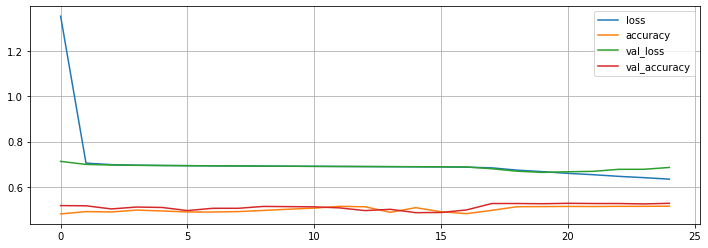

In [63]:
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

In [66]:
model.evaluate(X_test, y_test)

488/488 [==============================] - 1s 1ms/step - loss: 0.8271 - accuracy: 0.0917


[0.8270946145057678, 0.09173723310232162]

# Conclusion: 

